# Import the Data and Dependencies

IMPORT THE DEPENDENCIES

In [ ]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing dan pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Model machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    StackingRegressor
)
from xgboost import XGBRegressor
import xgboost as xgb

# Evaluasi model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

# Google Colab
from google.colab import drive

IMPORT THE DATA

In [ ]:
# prompt: mount to my drive
drive.mount('/content/drive')

train_df = pd.read_csv('/content/drive/MyDrive/Kaggle/OTI2425/Train.csv', index_col='id')
test_df = pd.read_csv('/content/drive/MyDrive/Kaggle/OTI2425/Test.csv', index_col='id')

Mounted at /content/drive


# Exploratory Data Analysis

In [ ]:
train_df['remote_ratio'].value_counts()


,count
remote_ratio,
0.0,21274
2.0,6756
1.0,32


Kita pastikan missing value pada data diperlakukan sebagai `np.nan` agar bisa dikenali oleh fungsi-fungsi `isna()`, `dropna()`, `fillna()`.

In [ ]:
# replace 'nan' or blanks with np.nan
train_df.replace('nan', np.nan, inplace=True)
train_df.replace('', np.nan, inplace=True)

Kita akan melihat datanya

In [ ]:
train_df.head()

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary
id,,,,,,,,,,
0,2024.0,NaN,FT,Data Engineer,USD,US,0.0,US,M,138000
1,2024.0,SE,FT,Software Engineer,USD,US,2.0,NaN,M,180000
2,2024.0,NaN,FT,Machine Learning Engineer,USD,US,0.0,US,M,118500
3,2024.0,NaN,NaN,Data Engineer,USD,US,0.0,US,M,180000
4,2024.0,SE,FT,Product Manager,USD,US,0.0,US,NaN,204000


Kita lihat jumalh baris dan kolomnya. Diketahui bahwa data memiliki 35078 baris dan 10 kolom dengan salah satu kolomnya adalah kolom target yaitu `salary`. Untuk ukuran ML, jumlah data ini cukup kecil. Proses pemodelan kita tidak akan memakan banyak sumber daya dan kemungkinan algoritma regresi umum bisa cukup baik menanganinya.

In [ ]:
train_df.shape

(35078, 10)

Kita lihat nama-nama kolom dan domain datanya. Diketahui bahwa data memiliki 7 kolom bertipe data kategorik dan 3 kolom bertipe data numerik.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35078 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           28062 non-null  float64
 1   experience_level    28062 non-null  object 
 2   employment_type     28062 non-null  object 
 3   job_title           35078 non-null  object 
 4   salary_currency     35078 non-null  object 
 5   employee_residence  28062 non-null  object 
 6   remote_ratio        28062 non-null  float64
 7   company_location    28062 non-null  object 
 8   company_size        28062 non-null  object 
 9   salary              35078 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 2.9+ MB


Kita hitung *summary statistic* dari kolom-kolom numerik

In [ ]:
train_df.describe()

,work_year,remote_ratio,salary
count,28062.000000,28062.000000,35078.000000
mean,2023.686373,0.482646,150517.661811
std,0.698085,0.855120,72965.037566
min,2020.000000,0.000000,15000.000000
25%,2024.000000,0.000000,99070.750000
50%,2024.000000,0.000000,140000.000000
75%,2024.000000,0.000000,191920.500000
max,2024.000000,2.000000,800000.000000


Kita lihat pula karakteristik dari kolom-kolom bertipe data kategorik

In [ ]:
train_df.describe(include=[('O')])

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,28062,28062,35078,35078,28062,28062,28062
unique,4,4,209,10,59,61,3
top,SE,FT,Data Scientist,USD,US,US,M
freq,15976,27500,5322,33830,23663,23724,25949


Kita perlu mamastikan bahwa tidak ada duplikasi data. Jika ada, kita drop data-data duplikat tersebut agar tidak memengaruhi proses-proses kita selanjutnya.

In [ ]:
train_df.duplicated().sum()

1729

Ternyata ada data duplikat. Kita drop data duplikat agar tidak mengganggu prose EDA.

In [ ]:
train_df.drop_duplicates(inplace=True)

Kita perlu mengetahui berapa banyak missing value pada setiap kolom.

In [ ]:
train_df.isnull().sum()

,0
work_year,6851
experience_level,6812
employment_type,6873
job_title,0
salary_currency,0
employee_residence,6886
remote_ratio,6848
company_location,6861
company_size,6875
salary,0


In [ ]:
test_df.isnull().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary_currency,0
employee_residence,0
remote_ratio,0
company_location,0
company_size,0


Sekarang kita masuk pada bagian visualisasi data

DISTRIBUSI NILAI FITUR TARGET `salary`

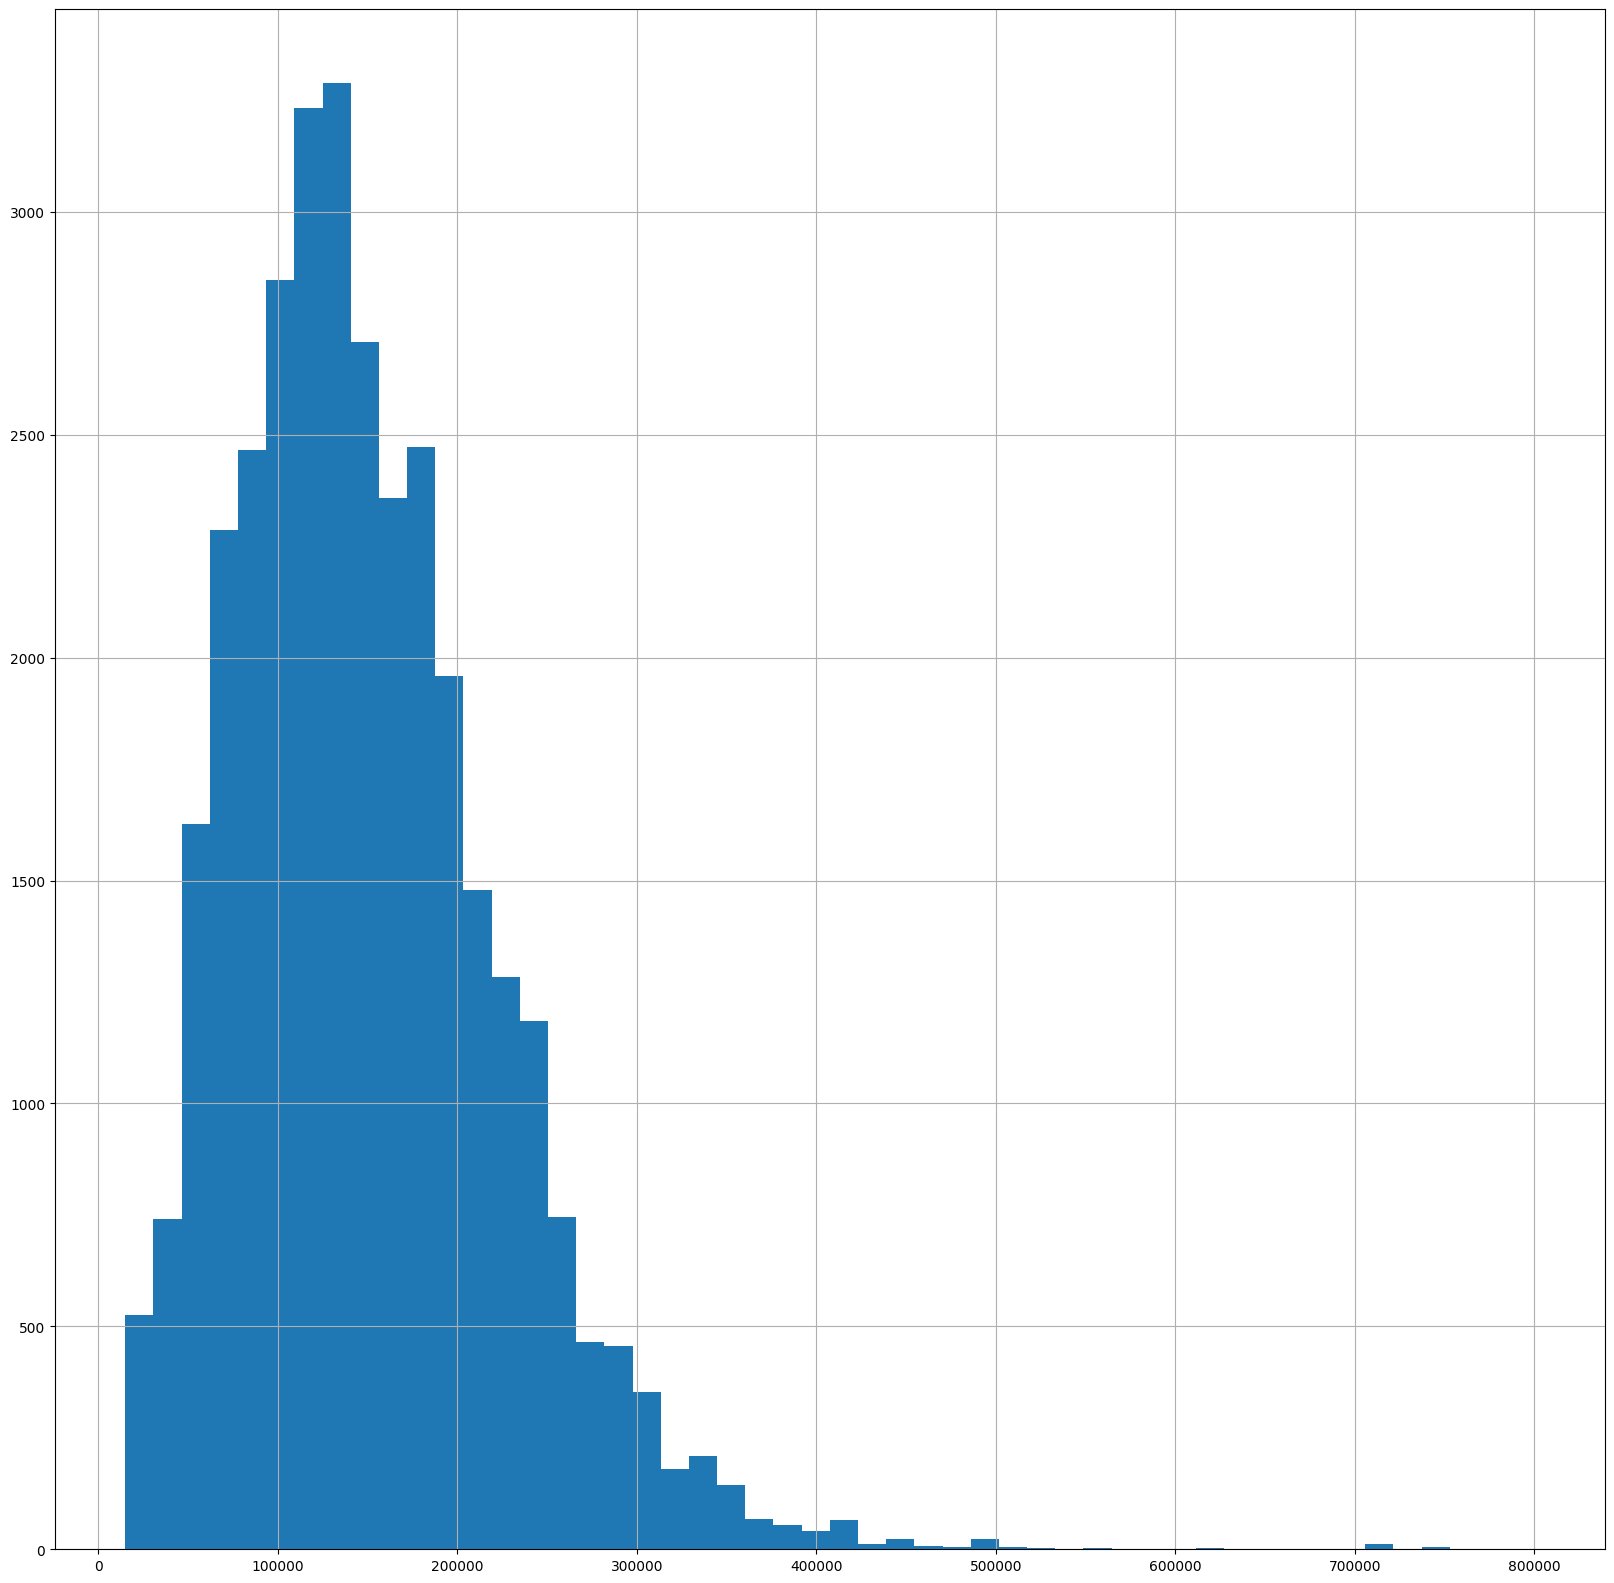

In [ ]:
# histplot
train_df['salary'].hist(bins=50, figsize=(20, 20))
plt.show()

Cukup meyakinkan bahwa distribusinya mendekati normal sampai kita ingat bahwa angka-angka itu berada dalam kurs matauang yang berbeda-beda. Kita akan mencoba melakukan sesuatu terhadap fakta ini nanti.

In [ ]:
train_df['salary_currency'].value_counts()

,count
salary_currency,
USD,32114
GBP,599
EUR,449
Other,115
CAD,51
INR,7
CHF,6
BRL,4
PLN,2


Dari tabel di atas, diketahui bahwa terdapat kejomplangan dalam distribusi `salary_currency`. USD dominan dengan persentase mendekati 97% dari total keseluruhan data kurs mata uang. Akan dicoba beberapa teknik untuk menangani ketidakmerataan data ini.

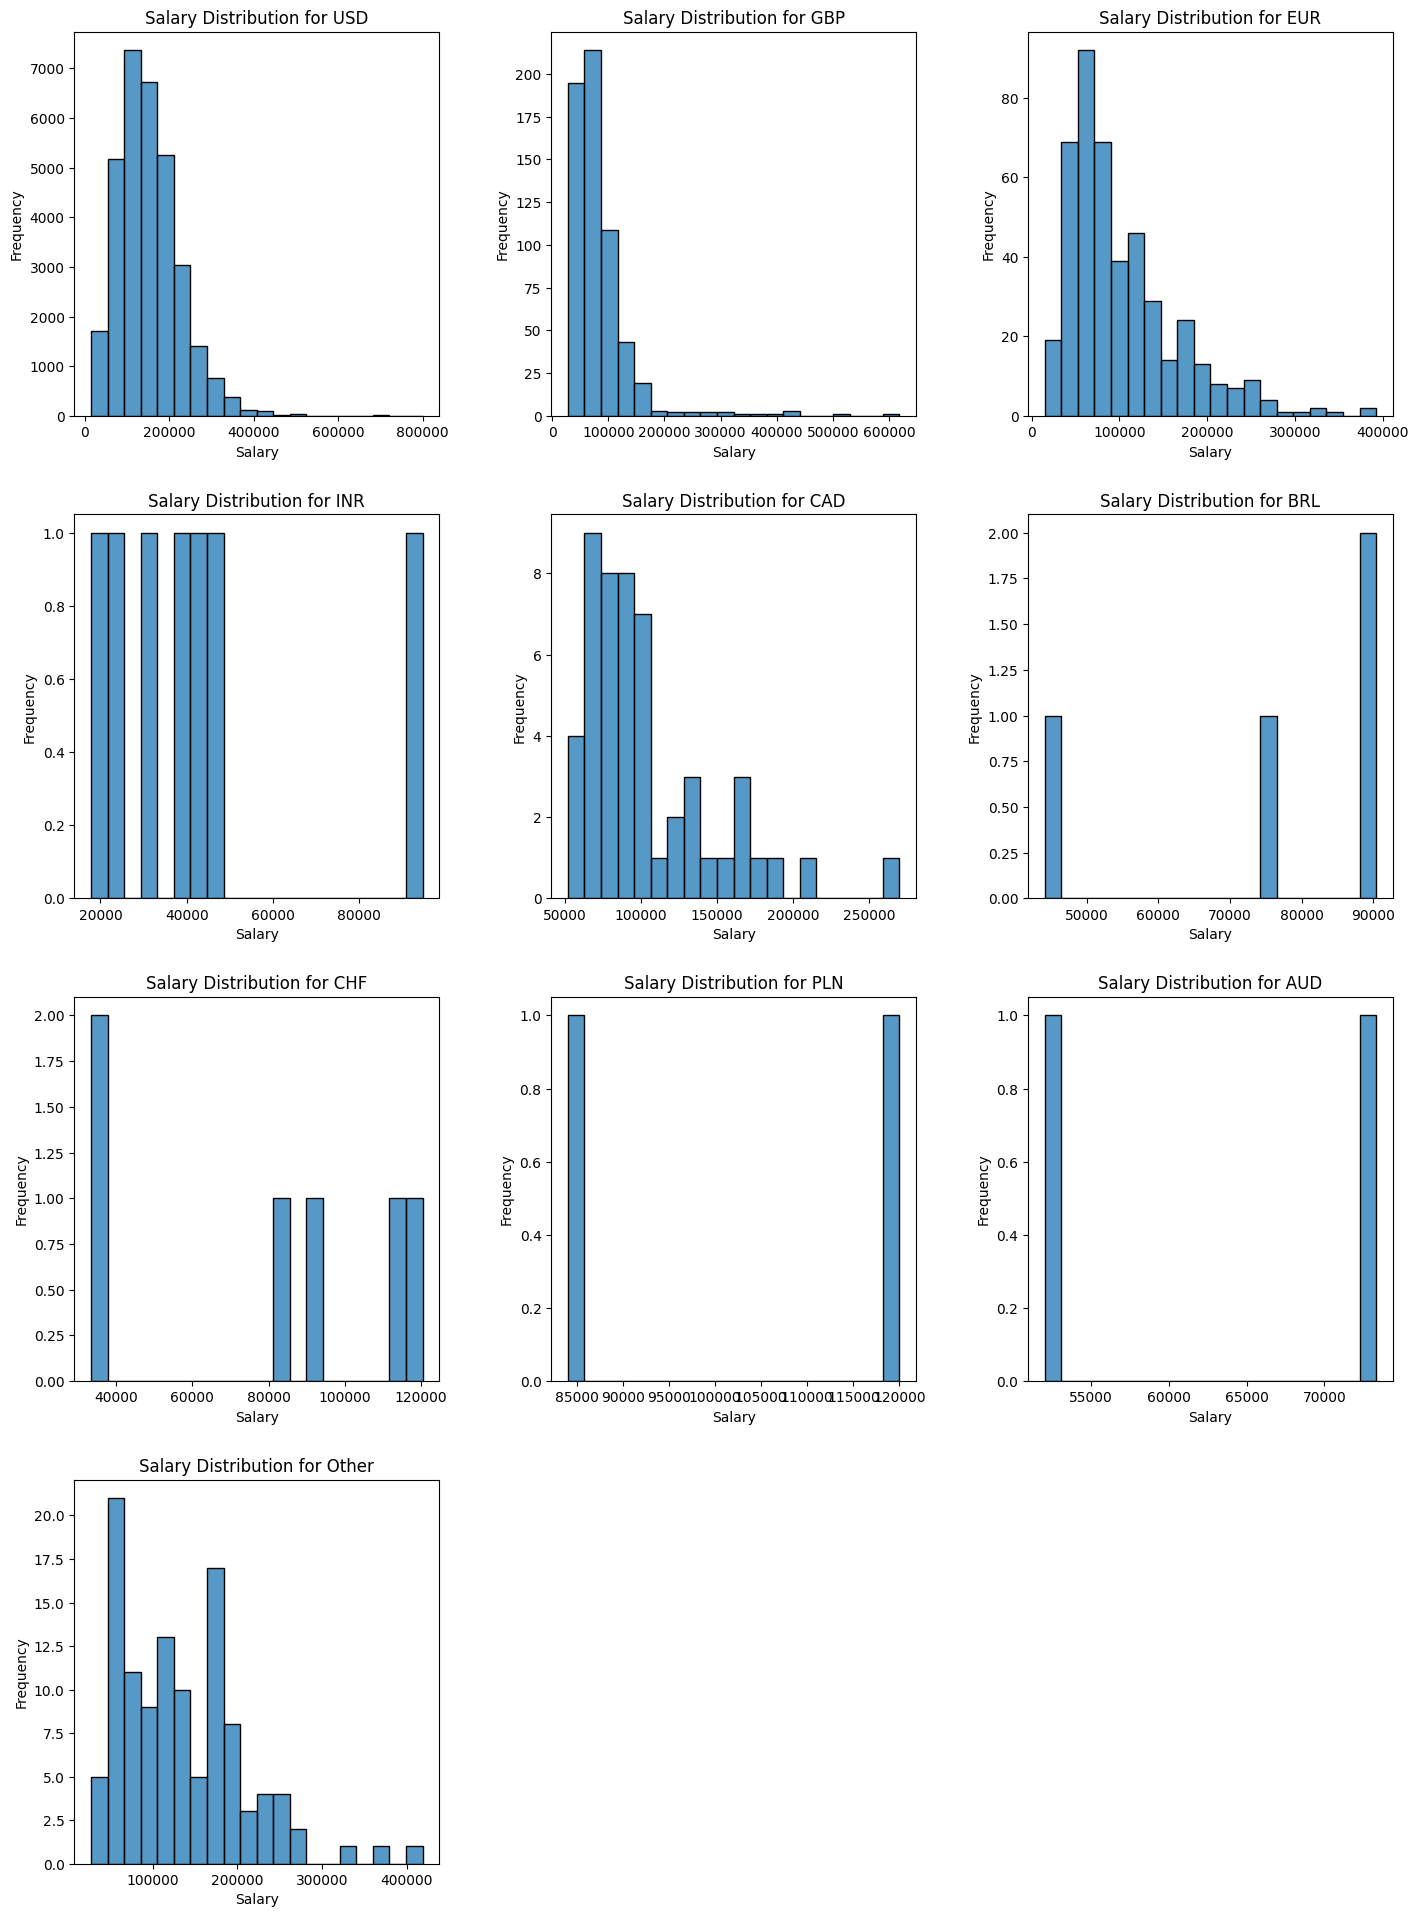

In [ ]:
# Create a histogram for each category of salary_currency
num_rows = (len(train_df['salary_currency'].unique()) + 2) // 3  # Calculate the number of rows needed
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))  # Create subplots
fig.tight_layout(pad=5.0)

axes = axes.flatten()  # Flatten the axes array for easier iteration
currency_counts = 0

for currency in train_df['salary_currency'].unique():
    try:
        subset = train_df[train_df['salary_currency'] == currency]
        sns.histplot(subset['salary'], ax=axes[currency_counts], bins=20)
        axes[currency_counts].set_title(f'Salary Distribution for {currency}')
        axes[currency_counts].set_xlabel('Salary')
        axes[currency_counts].set_ylabel('Frequency')
        currency_counts += 1
    except:
        pass

for i in range(currency_counts, len(axes)):
    fig.delaxes(axes[i])

plt.show()

<ipython-input-17-770a55b04323>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='salary_currency', y='salary', data=train_df, palette='dark')


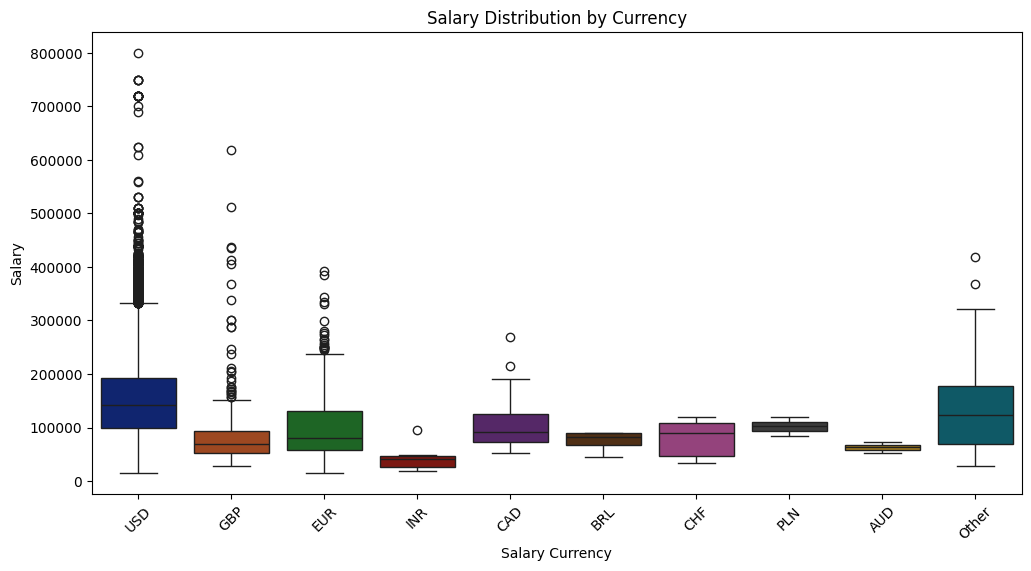

In [ ]:
# BoxPlot
plt.figure(figsize=(12, 6))
sns.boxplot(x='salary_currency', y='salary', data=train_df, palette='dark')
plt.title('Salary Distribution by Currency')
plt.xlabel('Salary Currency')
plt.ylabel('Salary')
plt.xticks(rotation=45)
plt.show()

Dari distribusi `salary` berdasarkan kurs mata uangnya `salary_currency`, bisa diambil kesimpulan
1. Distribusi gaji dalam USD sangat tinggi dibandingkan mata uang lainnya, menunjukkan bahwa dataset ini didominasi oleh pekerja yang dibayar dengan mata uang USD. Selain itu, distribusi gaji dalam USD menunjukkan adanya kemiringan positif dengan banyak outlier pada gaji tinggi.
2.  Distribusi dalam GBP, EUR, dan CAD menunjukkan pola serupa, yaitu kemiringan positif dengan beberapa outlier pada gaji yang lebih tinggi.
3. Distribusi untuk INR, BRL, CHF, PLN, dan AUD sangat terbatas dan hanya memiliki sedikit sampel, sehingga sulit untuk menganalisis pola secara akurat.
4. Data gaji dengan kategori 'Other' memiliki rentang yang cukup lebar dan menunjukkan kemiringan positif. Ini mungkin terjadi karena kurs yang berbeda-beda, sehingga sulit untuk menginterpretasi gaji secara langsung tanpa konversi ke mata uang standar.

Lihat relasi antara `experience_level` dan `salary`

<ipython-input-18-aebe83a40e3d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


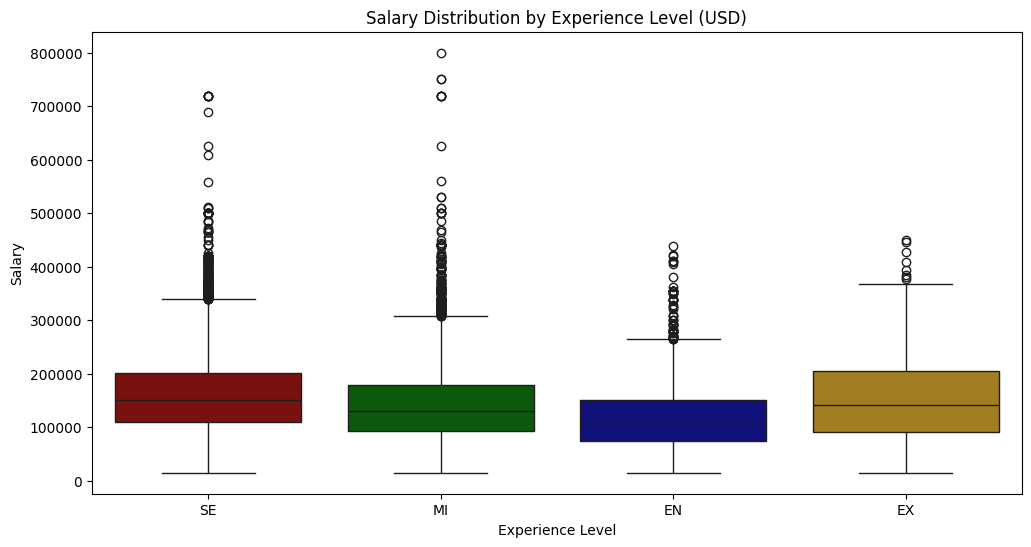

<ipython-input-18-aebe83a40e3d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


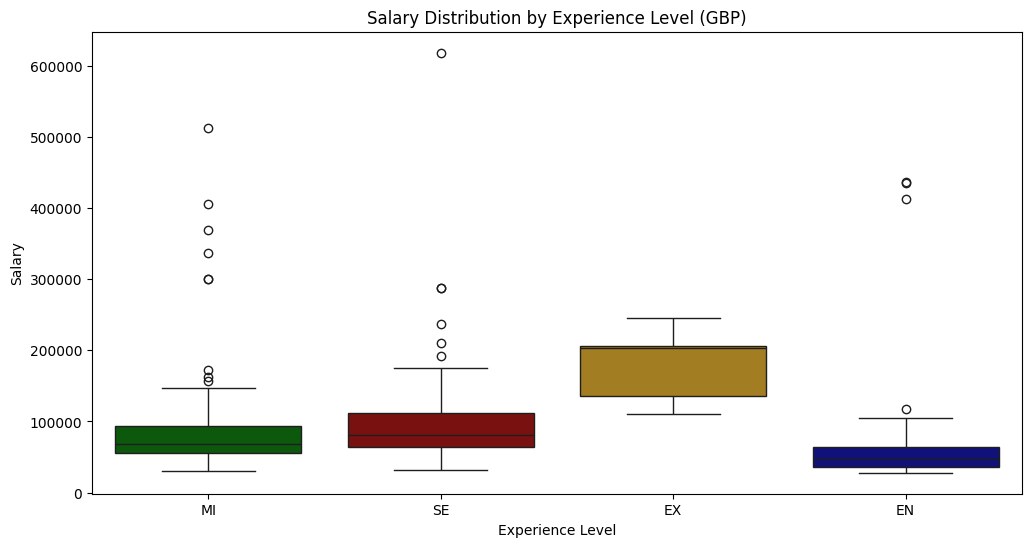

<ipython-input-18-aebe83a40e3d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


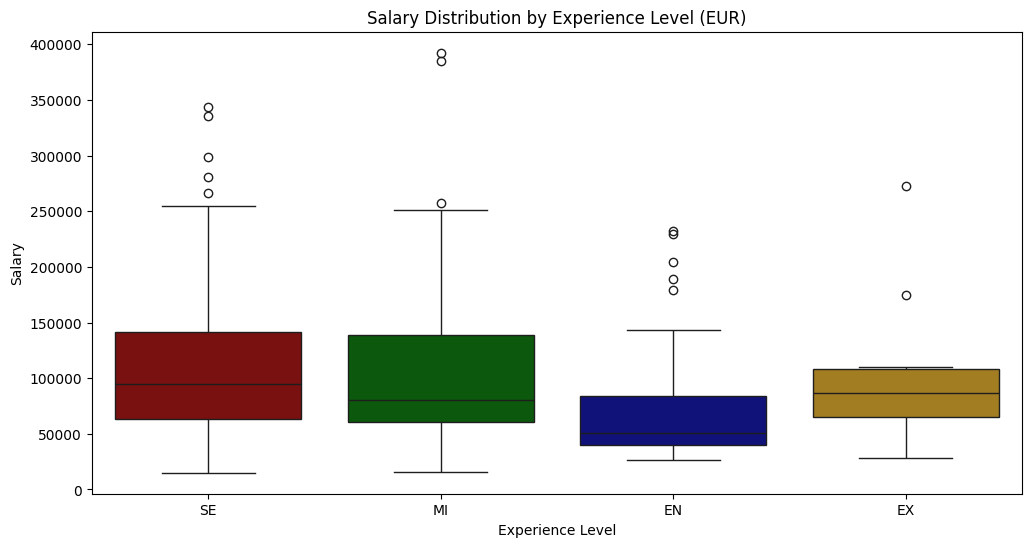

<ipython-input-18-aebe83a40e3d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


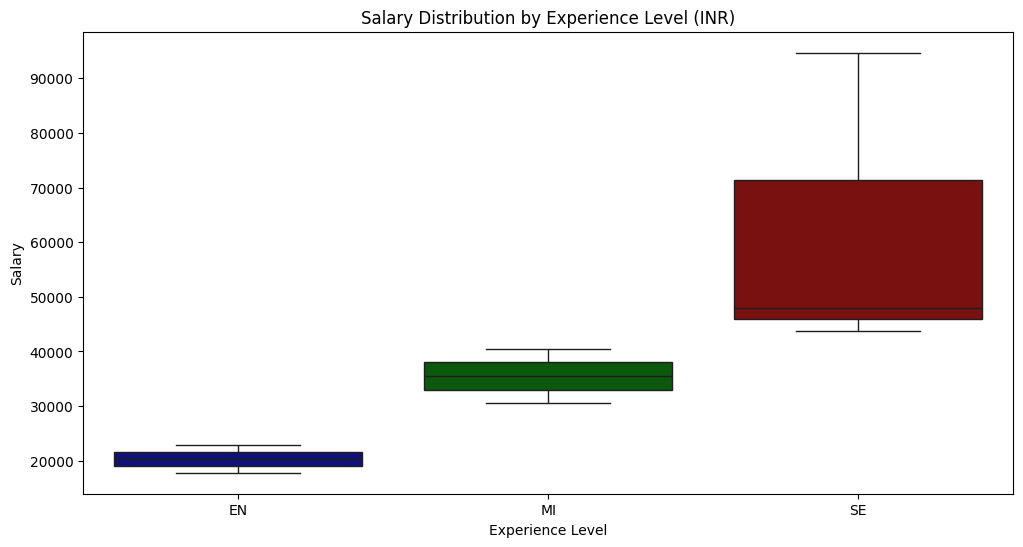

<ipython-input-18-aebe83a40e3d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


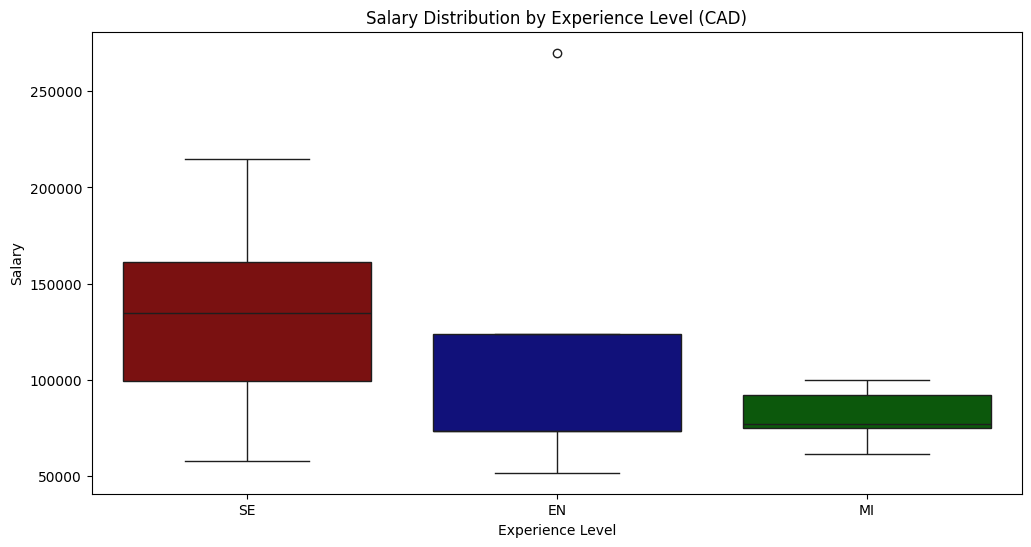

<ipython-input-18-aebe83a40e3d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


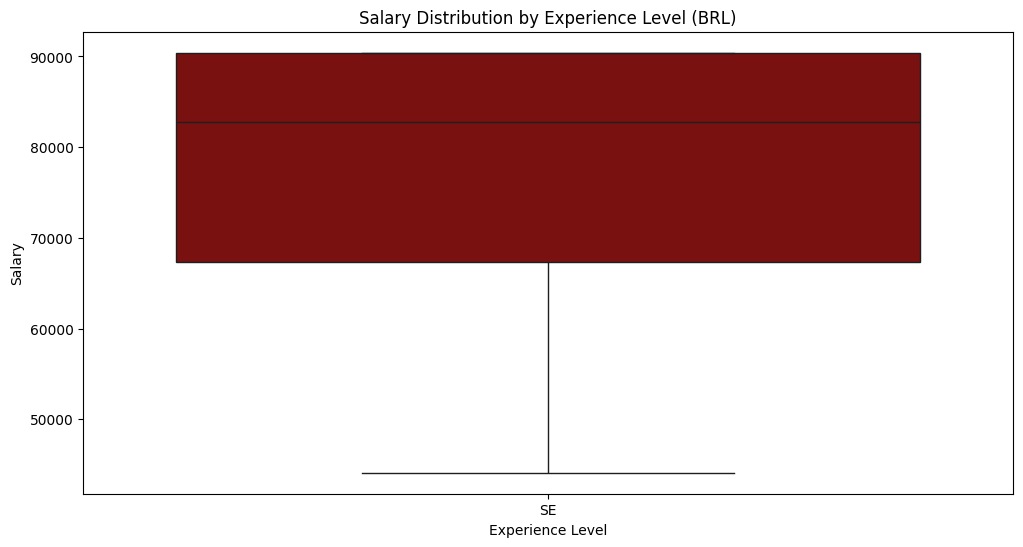

<ipython-input-18-aebe83a40e3d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


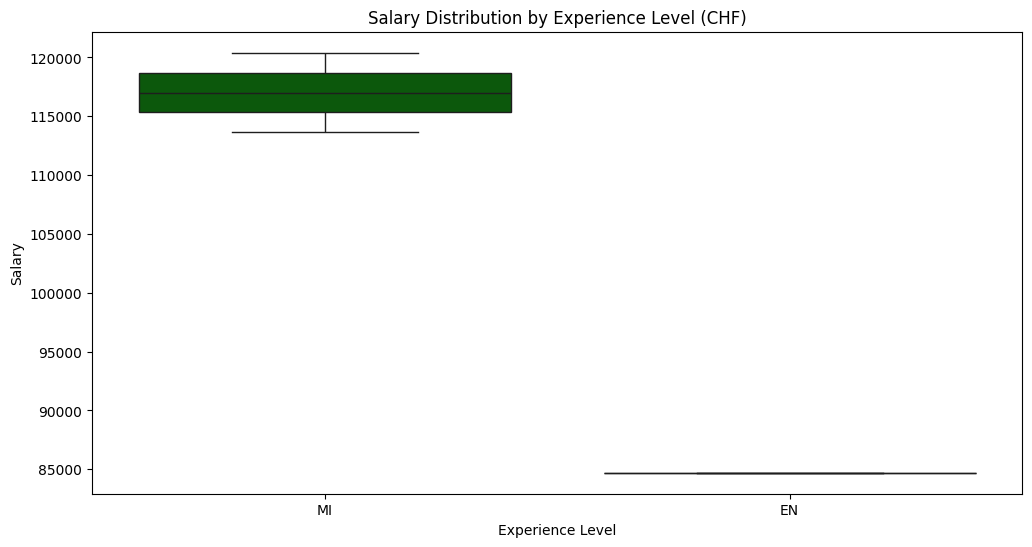

<ipython-input-18-aebe83a40e3d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


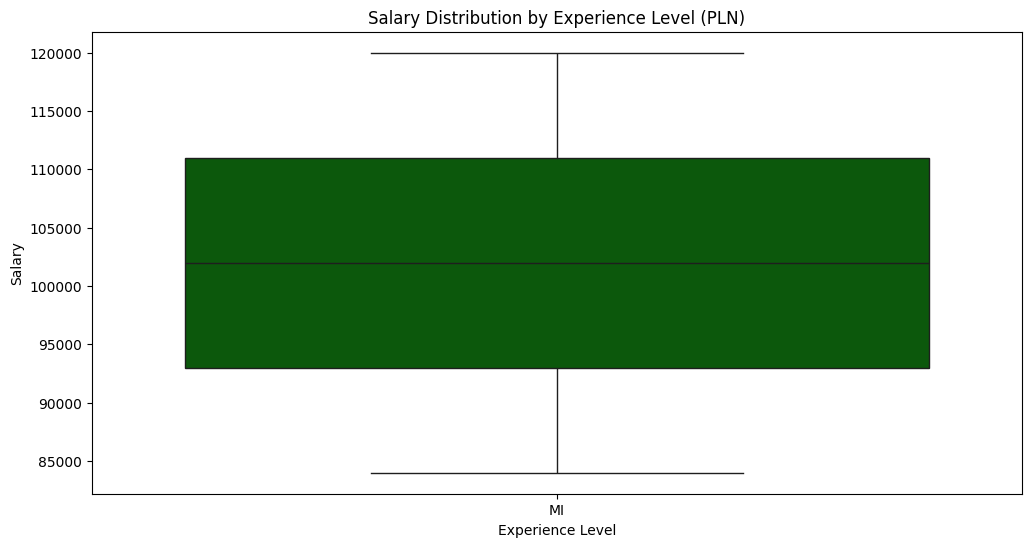

<ipython-input-18-aebe83a40e3d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


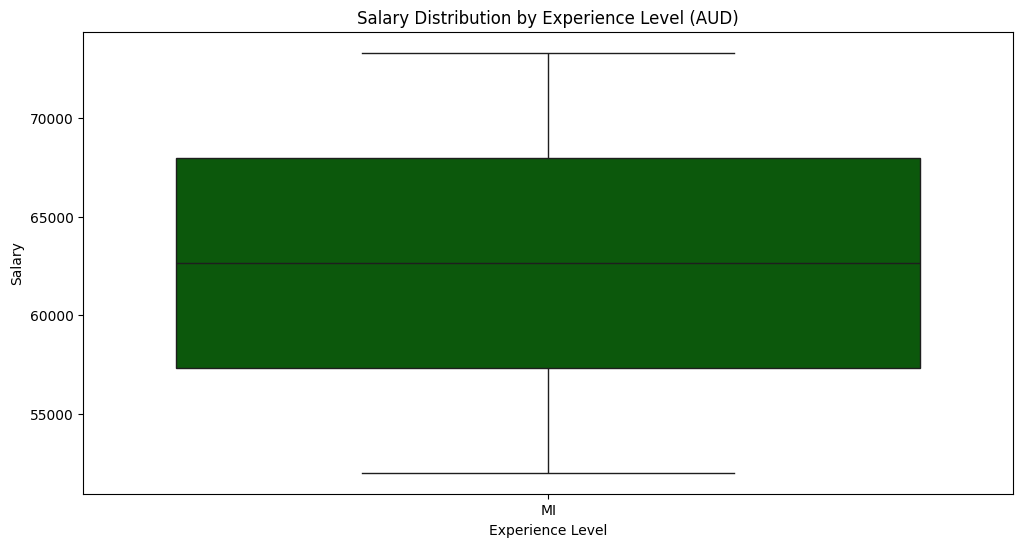

<ipython-input-18-aebe83a40e3d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


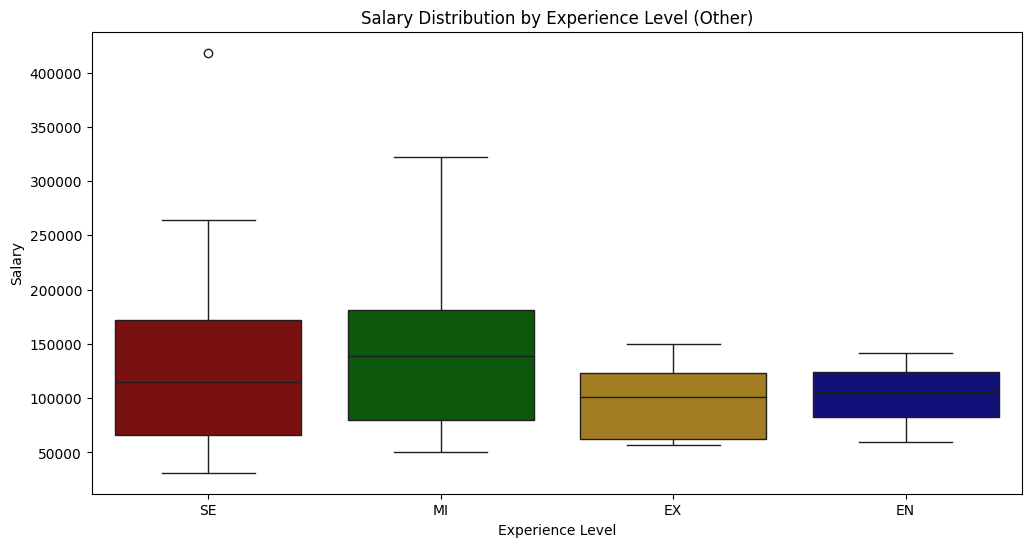

In [ ]:
# Define a color palette for experience levels (consistent across currencies)
experience_level_colors = {
    'EN': 'darkblue',
    'MI': 'darkgreen',
    'SE': 'darkred',
    'EX': 'darkgoldenrod'
}

# Create a boxplot for each currency
for currency in train_df['salary_currency'].unique():
  plt.figure(figsize=(12, 6))
  sns.boxplot(
      x='experience_level',
      y='salary',
      data=train_df[train_df['salary_currency'] == currency],
      palette=experience_level_colors
  )
  plt.title(f'Salary Distribution by Experience Level ({currency})')
  plt.xlabel('Experience Level')
  plt.ylabel('Salary')
  plt.show()

Secara umum, bisa diambil beberapa pola dari boxplot yang dibuat
1. Kategori EN (Entry-level) memiliki gaji yang paling rendah, sesuai dengan ekspektasi karena ini adalah level junior.
2. Secara umum, distribusi gaji meningkat seiring dengan level pengalaman, tetapi hanya terlihat pada beberapa grup kurs mata uang karena jumlah datanya mencukupi.
3. Median gaji pada SE (Senior-level) dan EX (Executive) sering bergantian menjadi yang tertinggi. Ini menunjukkan bahwa dua tipe pekerjaan ini memiliki pola ordinal (tingkatan) hanya dalam konteks jabatan, bukan gaji.



---



Lihat kolom `company_size` dan relasikan dengan `salary`

<ipython-input-19-9d709d9955f4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


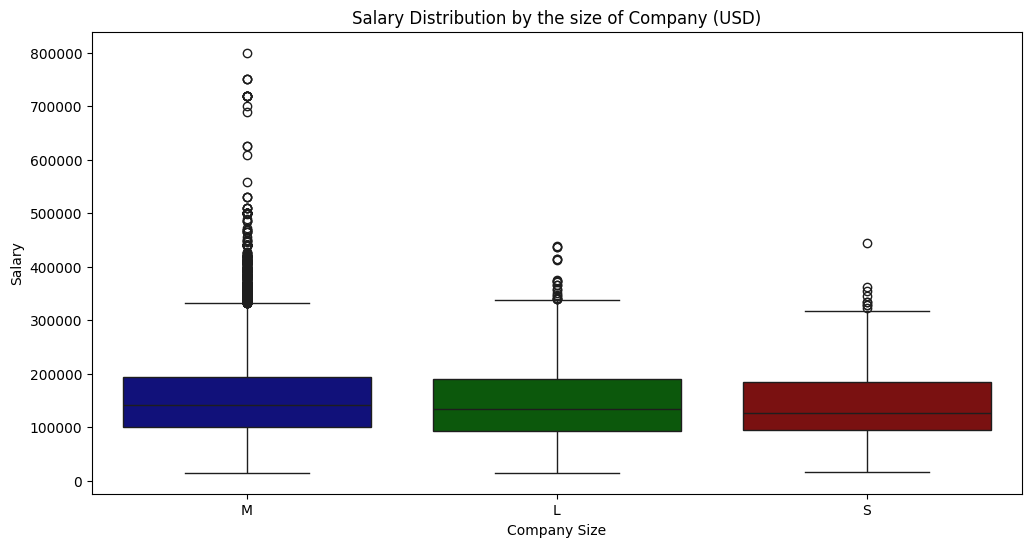

<ipython-input-19-9d709d9955f4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


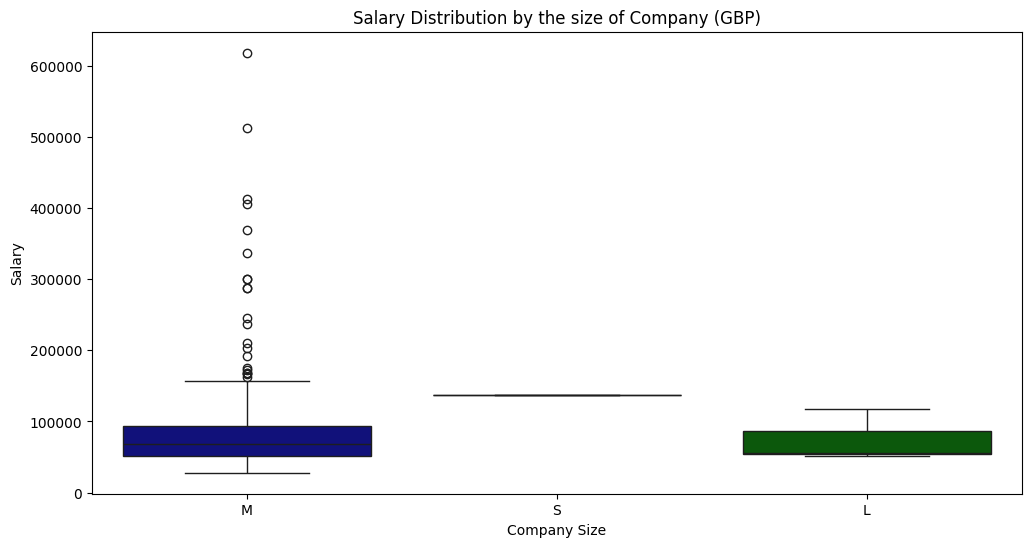

<ipython-input-19-9d709d9955f4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


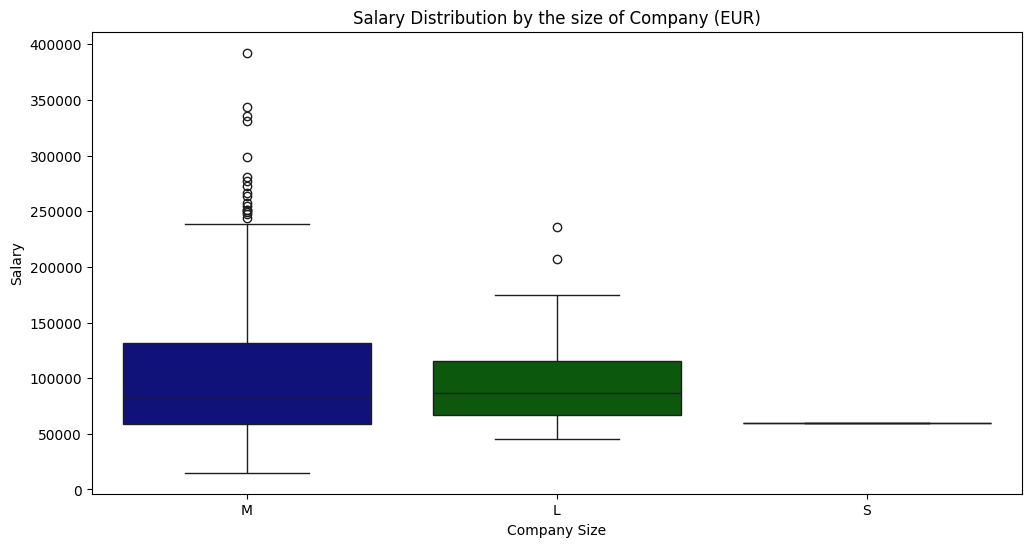

<ipython-input-19-9d709d9955f4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


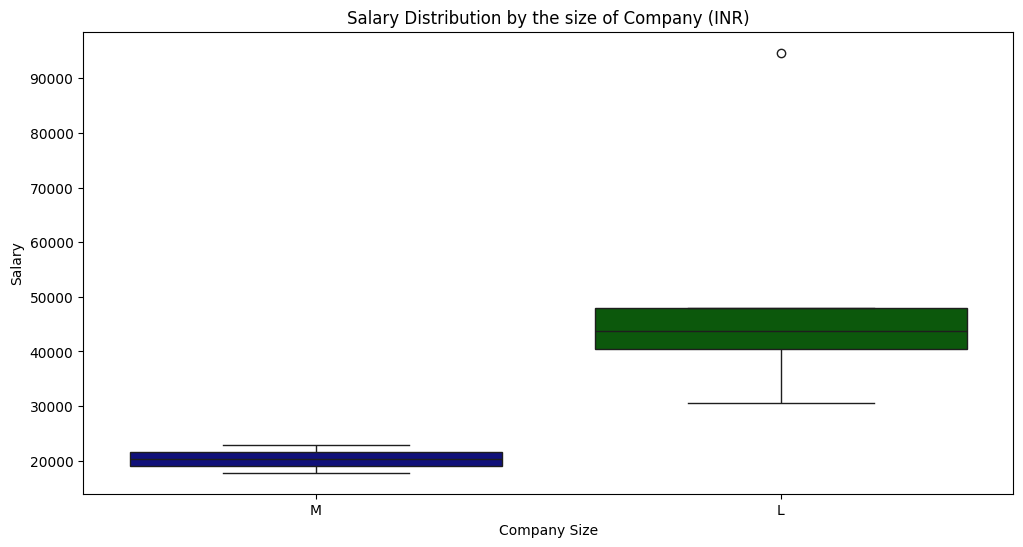

<ipython-input-19-9d709d9955f4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


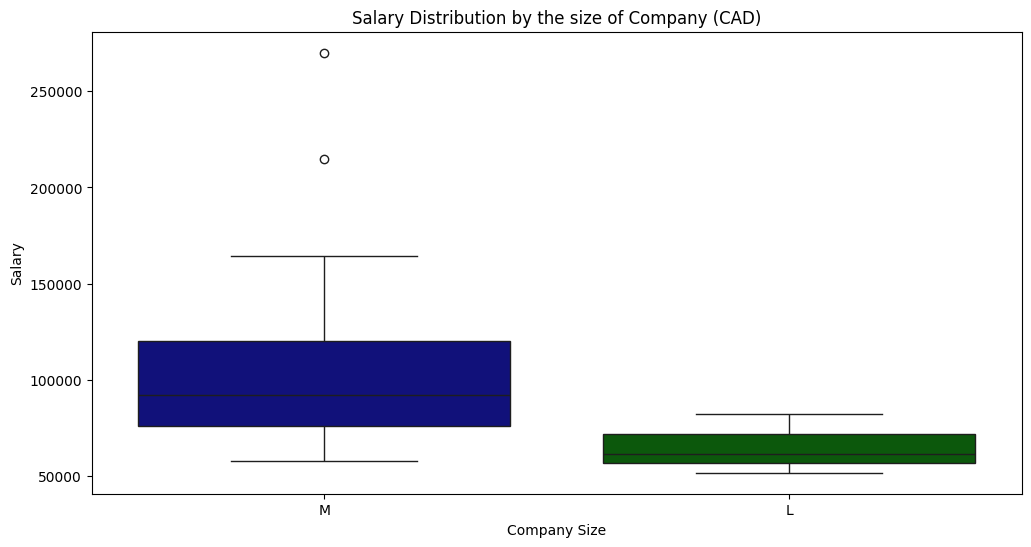

<ipython-input-19-9d709d9955f4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


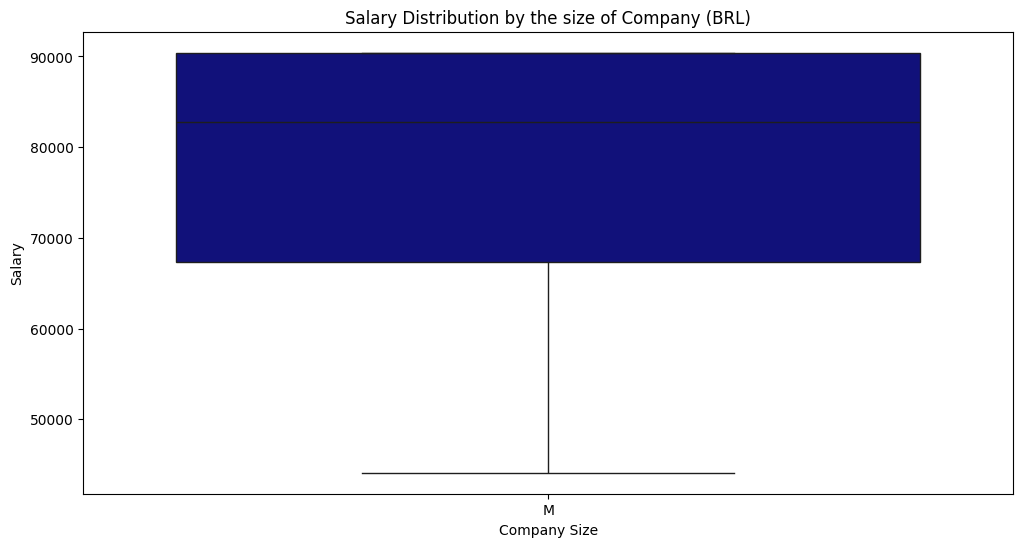

<ipython-input-19-9d709d9955f4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


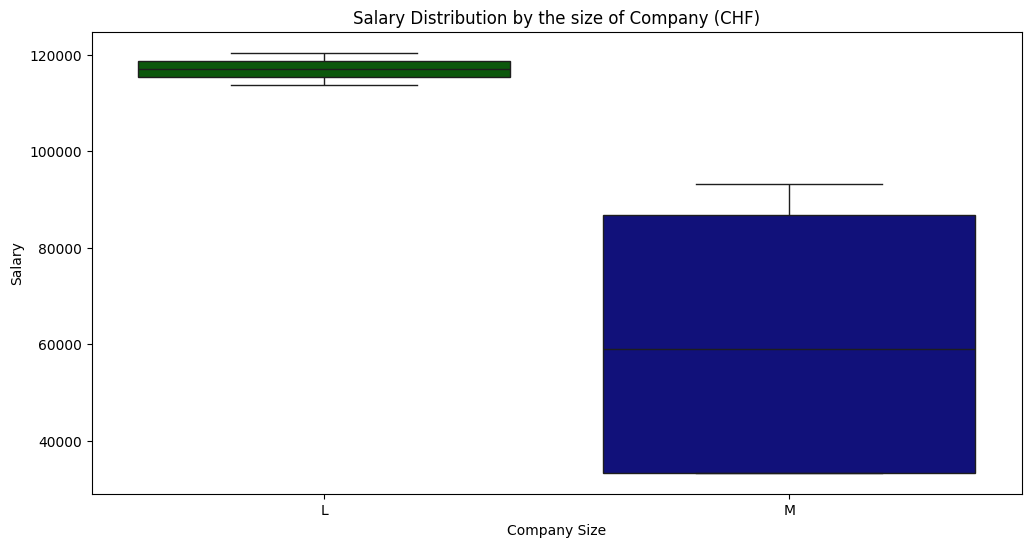

<ipython-input-19-9d709d9955f4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


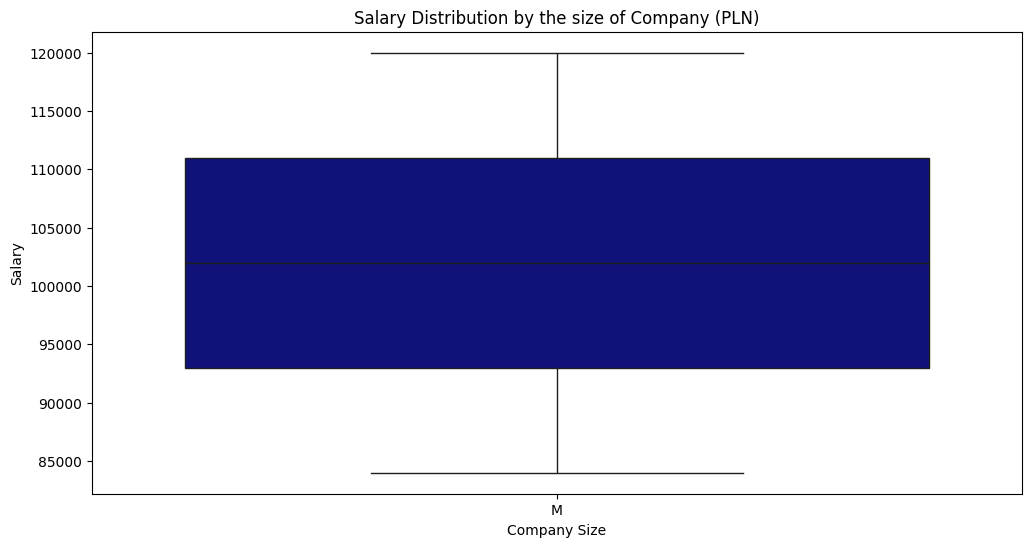

<ipython-input-19-9d709d9955f4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


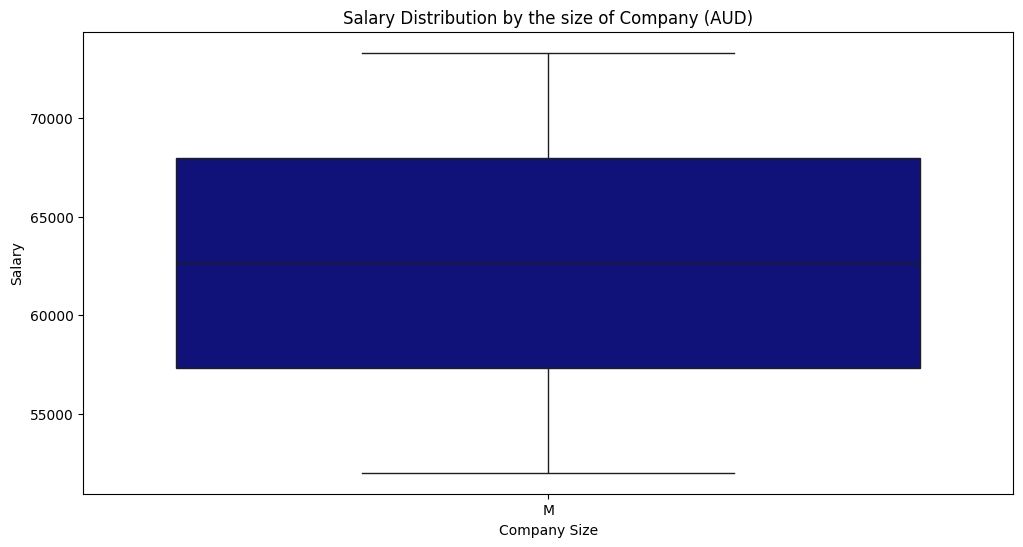

<ipython-input-19-9d709d9955f4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


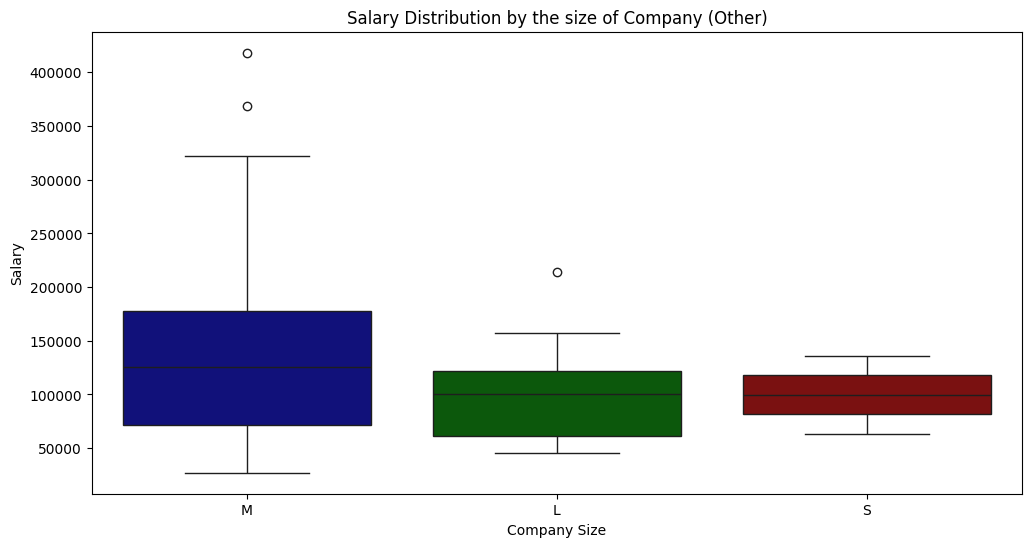

In [ ]:
# Define a color palette for company_size (consistent across currencies)
company_size_colors = {
    'M': 'darkblue',
    'L': 'darkgreen',
    'S': 'darkred',
}

# Create a boxplot for each currency
for currency in train_df['salary_currency'].unique():
  plt.figure(figsize=(12, 6))
  sns.boxplot(
      x='company_size',
      y='salary',
      data=train_df[train_df['salary_currency'] == currency],
      palette=company_size_colors
  )
  plt.title(f'Salary Distribution by the size of Company ({currency})')
  plt.xlabel('Company Size')
  plt.ylabel('Salary')
  plt.show()

Dari BoxPlot bisa ditarik beberapa fakta
1. Perusahaan small (S) memiliki rentang dan median gaji yang mirip dengan perusahaan large (L), yang bisa menunjukkan bahwa perusahaan kecil tertentu mungkin menawarkan gaji yang kompetitif untuk menarik talenta.
2. Meskipun perusahaan large (L) diharapkan memiliki kompensasi yang lebih tinggi, dalam grafik ini terlihat bahwa perusahaan medium (M) memiliki distribusi gaji yang lebih tinggi dan lebih bervariasi.
3. Terlihat banyak outlier pada ketiga kategori, terutama pada perusahaan medium (M). Outlier ini merepresentasikan gaji yang jauh lebih tinggi dari rentang normal, yang mungkin menunjukkan posisi dengan kompensasi tinggi atau bonus besar di perusahaan ukuran sedang.



---



Lihat kolom `job_title`

In [ ]:
train_df['job_title'].value_counts().to_frame()

,count
job_title,
Data Scientist,4927
Data Engineer,4818
Data Analyst,3967
Software Engineer,3011
Machine Learning Engineer,2218
...,...
Data Integration Coordinator,2
Data Integration Analyst,2
Data Management Manager,2


Terdapat variasi yang tinggi pada kolom `job_title`. Total ada 209 jenis pekerjaan berbeda dalam kolom tersebut. Kita akan mereduksinya menjadi beberapa kategori saja, seperti apakah employer itu seorang engineer, scientist, analyst, ataukah mengurusi bidang data, software, dan database.



---



Lihat kolom `salary_currency`

In [ ]:
train_df['salary_currency'].value_counts()

,count
salary_currency,
USD,32114
GBP,599
EUR,449
Other,115
CAD,51
INR,7
CHF,6
BRL,4
PLN,2


Ada beberapa poin penting yang perlu diperhatikan dari informasi-informasi di atas
1. Kita bisa melihat bahwa ada ketidakmerataan jumlah data pada masing-masing kategori `salary_currency`.
2. Ada nilai 'Other' pada kolom `salary_currency`, padahal fitur ini krusial bagi kita karena fitur ini menentukan dalam kurs apa value `salary` dibayarkan.

Untuk menangani permasalahan nilai 'Other' pada kolom `salary_currency` kita akan menggunakan fitur bantu `employee_residence` dan `company_location`. Kita akan melakukannya di tahap Data Preprocessing.

In [ ]:
df_other_currency = train_df[train_df['salary_currency'] == 'Other']
df_other_currency

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary
id,,,,,,,,,,
30366,2023.0,SE,FT,Data Analyst,Other,MX,2.0,MX,M,61659
30382,2024.0,MI,FT,Data Scientist,Other,US,2.0,US,M,50056
30386,2023.0,SE,FT,Data Analyst,Other,MX,2.0,MX,M,66992
30611,NaN,SE,FT,Software Engineer,Other,US,NaN,US,M,223946
31100,2024.0,EX,FT,Data Analyst,Other,NaN,0.0,US,M,57099
...,...,...,...,...,...,...,...,...,...,...
49036,2024.0,NaN,FT,Data Engineer,Other,US,NaN,US,M,180701
49401,2024.0,SE,FT,Software Engineer,Other,CH,NaN,NaN,M,81760
49669,2024.0,EX,PT,Data Analyst,Other,US,2.0,NaN,M,101422


Kita akan melihat apakah ada pekerja yang tempat tinggalnya tidak sama dengan domisili perusahaan.

In [ ]:
data = train_df[
    (train_df['employee_residence'] != train_df['company_location']) &
    (train_df['employee_residence'].notnull()) &
    (train_df['company_location'].notnull()) &
    (train_df['salary_currency'] != 'Other')
]
data

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary
id,,,,,,,,,,
28761,2021.0,MI,NaN,Autonomous Vehicle Technician,USD,AS,1.0,BS,M,45555
30241,2021.0,NaN,NaN,AI Scientist,USD,CL,NaN,US,M,55434
30330,NaN,EX,NaN,Data Engineer,USD,US,0.0,CA,M,108588
30492,2024.0,SE,FT,Big Data Engineer,USD,RO,NaN,RU,M,69139
30688,2020.0,SE,NaN,Data Engineer,USD,US,2.0,JP,M,247456
...,...,...,...,...,...,...,...,...,...,...
49326,2022.0,SE,FT,Data Analyst,USD,PT,2.0,AM,M,90206
49449,2024.0,SE,FT,Research Scientist,USD,RU,0.0,HN,M,72510
49466,2024.0,SE,NaN,Data Engineer,USD,LT,0.0,ES,NaN,88736


Ternyata ada pekerja yang melakukan *remote working*. Masuk akal bagi kita untuk mengisi nilai 'Other' pada kolom `salary_currency` dengan kurs mata uang negara tempat perusahaan berlokasi. Kita akan melakukannya di bagian Data Preprocessing.



---



Lihat kolom `experience level`

In [ ]:
train_df['experience_level'].value_counts()

,count
experience_level,
SE,14921
MI,8049
EN,2405
EX,1162


Terdapat ketidakseimbangan jumlah data dalam fitur ini. Akan dikakukan eksperimen penanganan ketidakseimbangan. Akan juga dilakukan eksperimen penggunaan algoritma yang tahan terhadap ketidakseimbangan data.

Kolom experience level bertipe kategorik ordinal. Artinya adalah masing-masing value dalam kolom ini memiliki urutannya. Dalam konteks ini EX > SE > MI > EN. Meng-*encoding* fitur bertipe ordinal harus memakai *ordinal encoding*, bukan *one-hot*, agar model bisa mengetahui bahwa nilai-nilai dalam fitur mencerminkan ururtan tertentu.



---



Lihat kolom `employment_type`

In [ ]:
train_df['employment_type'].value_counts()

,count
employment_type,
FT,25915
CT,269
PT,200
FL,92


Terdapat ketidakseimbangan, bahkan kejomplangan yang jauh antara tipe FT (Full-time) dengan tipe lain. Akan dilakukan beberapa eksperimen teknik-teknik penanganan ketidakseimbangan data, seperti menggunakan parameter `class_weight` pada algoritma dan `StratifiedKFold` sampling. Selain itu, akan dilakukan eksperimen penggunaan algoritma yang tahan terhadap ketidakseimbangan data, seperti XGBoost dan CatBoost.



---



Lihat kolom `company_size`

In [ ]:
train_df['company_size'].value_counts()

,count
company_size,
M,24462
L,1649
S,363


Di fitur ini juga terlihat ketidakseimbangan data. Akan dilakukan hal yang sama pada tahap *data preprocessing*.



---



Sekarang, kita lihat kekuatan hubungan antarfitur dengan bantuan Korelasi Pearson

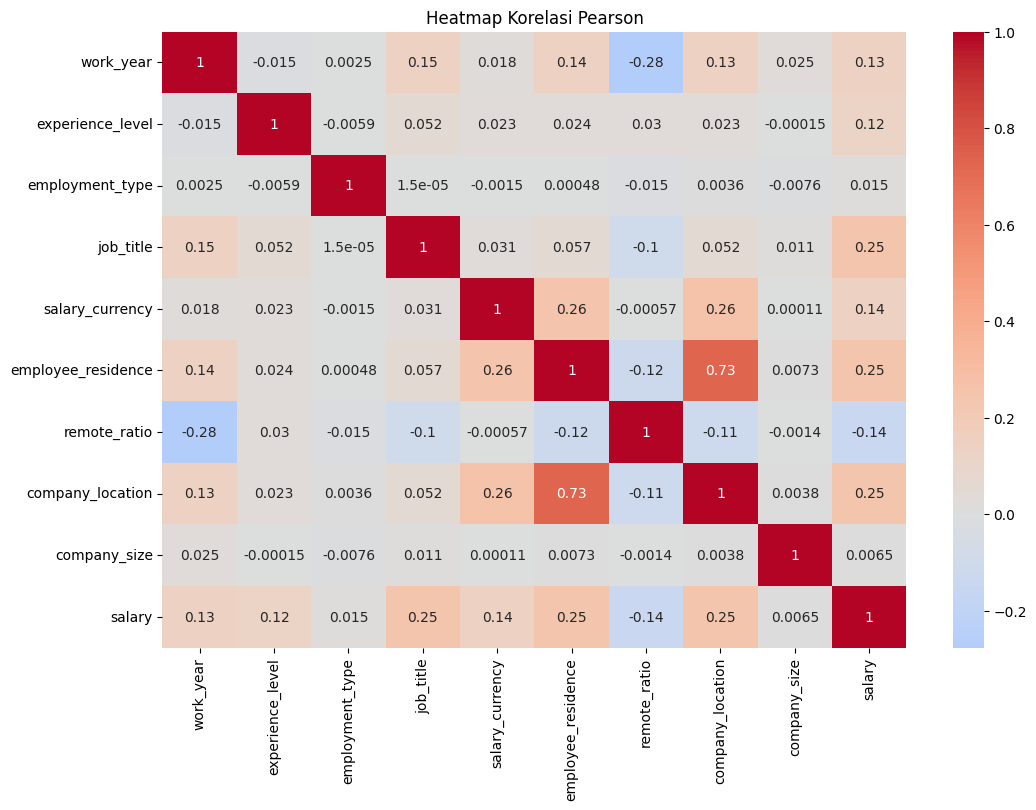

In [ ]:
# Copy dataset untuk praproses
df = train_df.copy()

# Label Encoding untuk fitur kategori
cat_cols = ['experience_level', 'employment_type', 'job_title', 'salary_currency',
            'employee_residence', 'company_location', 'company_size']

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Menghitung korelasi Pearson untuk semua fitur
corr_matrix = df.corr()

# Visualisasi Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap= 'coolwarm', center=0)
plt.title("Heatmap Korelasi Pearson")
plt.show()

Cukup mengejutkan mengetahui bahwa besar kecilnya perusahaan `companay_size` tidak banyak berpengaruh terhadap `salary` pegawainya. Begitu juga dengan `employment_type`, angka korelasinya mendekati 0 atau hampir tidak ada hubungan sama sekali. Kita mungkin bisa bereksperimen dengan menanyakan apakah membuang dua fitur ini memperbaiki kualitas prediksi model? Kita akan lihat hasilnya pada tahap Pemodelan.

# Penyiapan Data (*Data Preprocessing*)

Lihat ulang jumlah data hilang pada data latih.

In [ ]:
train_df.isnull().sum()

,0
work_year,6851
experience_level,6812
employment_type,6873
job_title,0
salary_currency,0
employee_residence,6886
remote_ratio,6848
company_location,6861
company_size,6875
salary,0


Dengan jumlah data sebanyak 33.349 entri, 6800-an data hilang bukanlah kabar baik. Jumlah itu mencapai 20% atau seperlima dari jumlah entri, sebuah persentase yang besar. Untuk itu, perlu kehati-hatian dalam mengisi data hilang. Pengisian dengan metode sederhana seperti modus dan median terlalu berisiko. Untuk itu, akan digunakan metode yang lebih advanced, seperti algoritma ML Random Forest. Selain itu, dengan menggunakan *logical sense* kita bisa mengisi data hilang dengan data dari fitur lain yang secara logika berhubungan kuat.

Perlu diketahui apakah data tes aman ataukah perlu dilakukan sesuatu juga.

In [ ]:
test_df.isnull().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary_currency,0
employee_residence,0
remote_ratio,0
company_location,0
company_size,0


In [ ]:
test_df['salary_currency'].value_counts()

,count
salary_currency,
USD,8487
GBP,149
EUR,100
Other,25
CAD,8
INR,1


Tidak ada permasalahan *missing value* pada data tes, tetapi ada nilai 'other' pada `salary_currency` data tes. Kita bisa menggantinya dengan metode yang sama pada data latih.



---



Mengisi missing value pada masing-masing fitur `company_location` dan `employee_residence` dengan value salah satunya.

In [ ]:
# Fill missing values in 'company_location' with 'employee_residence' if available
train_df['company_location'].fillna(train_df['employee_residence'], inplace=True)

# Fill missing values in 'employee_residence' with 'company_location' if available
train_df['employee_residence'].fillna(train_df['company_location'], inplace=True)

<ipython-input-31-0db5e2f6e62d>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['company_location'].fillna(train_df['employee_residence'], inplace=True)
<ipython-input-31-0db5e2f6e62d>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].metho



---



Pengubahan Nilai 'Other' pada Kolom `salary_currency` dengan Kurs Mata Uang Negara Tempat Perusahaan Berada.

In [ ]:
df_other_currency['company_location'].value_counts()

,count
company_location,
US,70
GB,8
MX,2
PL,2
FI,2
TR,2
IN,2
CH,2
ES,2


Karena hanya ada 10 negara, mudah bagi kita untuk mapping kode negara ke kode kurs mata uangnya. Lakukan langkah ini sekaligus untuk data tes.

In [ ]:
# Dictionary mapping ISO 3166 country codes ke ISO 4217 currency codes
country_to_currency = {
    'US': 'USD',
    'GB': 'GBP',
    'MX': 'MXN',
    'PL': 'PLN',
    'FI': 'EUR',
    'TR': 'TRY',
    'IN': 'INR',
    'CH': 'CHF',
    'ES': 'EUR',
    'CA': 'CAD'
}

# Mengubah nilai 'Other' pada kolom salary_currency train_df
train_df['salary_currency'] = train_df.apply(
    lambda row: country_to_currency.get(row['company_location'], row['salary_currency'])
    if row['salary_currency'] == 'Other' else row['salary_currency'],
    axis=1
)
# Mengubah nilai 'Other' pada kolom slaary_currency test_df
test_df['salary_currency'] = test_df.apply(
    lambda row: country_to_currency.get(row['company_location'], row['salary_currency'])
    if row['salary_currency'] == 'Other' else row['salary_currency'],
    axis=1
)
# Memeriksa hasil perubahan
print(train_df[['company_location', 'salary_currency']].head(20))

   company_location salary_currency
id                                 
0                US             USD
1                US             USD
2                US             USD
3                US             USD
4                US             USD
5                US             USD
10               US             USD
11               US             USD
12               US             USD
13               US             USD
14               GB             GBP
15               US             USD
16               US             USD
18               US             USD
20               US             USD
21               US             USD
22               GB             GBP
24               US             USD
26               US             USD
27               US             USD


In [ ]:
train_df['salary_currency'].value_counts()

,count
salary_currency,
USD,32196
GBP,608
EUR,453
CAD,52
CHF,10
INR,9
Other,7
BRL,4
PLN,4


Masih ada 7 nilai 'Other' pada kolom `salary_currency`. Kita biarkan untuk sementara untuk eksperimen peforma model. Jika dengan menghilangkan 7 data itu memperbaiki peforma, kita lakukan.



---



Isi missing value yang masih tersisa pada `employee_residence` dan `company_location` dengan negara berdasarkan kurs mata uangnya (kolom `salary_currency`).

In [ ]:
# Find rows where both 'employee_residence' and 'company_location' are null
null_residence_location = train_df[(train_df['employee_residence'].isnull()) & (train_df['company_location'].isnull())]

# Print the data
null_residence_location['salary_currency'].value_counts()

,count
salary_currency,
USD,1316
GBP,19
EUR,17
Other,7
INR,2
CAD,2
CHF,1


Kita akan mapping keenam kurs mata uang ke negara. Informasi ini akan digunakan untuk mengisi missing value pada `company_location` dan `employee_residence`.

In [ ]:
# Create a dictionary mapping salary currency to country code (ISO 3166)
currency_to_country = {
    'USD': 'US',
    'EUR': 'DE',  # Default to Germany for EUR, you can adjust based on your data
    'GBP': 'GB',
    'CAD': 'CA',
    'INR': 'IN',
    'CHF': 'CH',
}

# Function to fill missing values based on salary currency
def fill_missing_residence_location(row):
    if pd.isnull(row['employee_residence']):
        if row['salary_currency'] in currency_to_country:
            return currency_to_country[row['salary_currency']]
    return row['employee_residence']

def fill_missing_location_residence(row):
    if pd.isnull(row['company_location']):
        if row['salary_currency'] in currency_to_country:
            return currency_to_country[row['salary_currency']]
    return row['company_location']

# Apply the function to fill missing values in 'employee_residence' and 'company_location'
train_df['employee_residence'] = train_df.apply(fill_missing_residence_location, axis=1)
train_df['company_location'] = train_df.apply(fill_missing_location_residence, axis=1)



---



Isi Missing Value pada `work_year` dengan bantuan fitur-fitur lain. Perlu untuk diperhatikan bahwa jumlah data hilang pada kolom `work_year` dan `remote_ratio` sangat banyak relatif terhadap total data. Persentase data hilang mencapai

Dari matriks korelasi diketahui bahwa `work_year` memiliki korelasi yang cukup baik dengan `company_location`, `remote_ratio`, `employee_residence`, dan `job_title`. Untuk itu, kita akan memanfaatkan algoritma Random Forest untuk mengisi missing valuenya.

In [ ]:
# Memisahkan data yang memiliki missing values pada work_year
df_missing = train_df[train_df['work_year'].isnull()]
df_not_missing = train_df[train_df['work_year'].notnull()]

# Fitur yang akan digunakan sebagai prediktor
features = ['company_location', 'remote_ratio', 'employee_residence', 'job_title']
target = 'work_year'

# Inisialisasi LabelEncoder dan melakukan encoding pada seluruh dataset
le = LabelEncoder()

for col in ['company_location', 'employee_residence', 'job_title']:
    # Menggabungkan data untuk encoding agar semua label dikenali
    le.fit(pd.concat([df_not_missing[col], df_missing[col]], axis=0).astype(str))
    df_not_missing[col] = le.transform(df_not_missing[col].astype(str))
    df_missing[col] = le.transform(df_missing[col].astype(str))

# Memisahkan fitur prediktor dan target
X_train = df_not_missing[features]
y_train = df_not_missing[target]
X_missing = df_missing[features]

# Melatih model Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Melakukan prediksi untuk missing values
predicted_work_year = rf_model.predict(X_missing)

# Mengisi missing values pada kolom 'work_year' di dataset asli
train_df.loc[train_df['work_year'].isnull(), 'work_year'] = predicted_work_year

# Cek apakah masih ada missing values pada 'work_year'
print("Jumlah missing values pada 'work_year' setelah imputasi:", train_df['work_year'].isnull().sum())


<ipython-input-37-a7350c58cc1c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_missing[col] = le.transform(df_not_missing[col].astype(str))
<ipython-input-37-a7350c58cc1c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing[col] = le.transform(df_missing[col].astype(str))
<ipython-input-37-a7350c58cc1c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Jumlah missing values pada 'work_year' setelah imputasi: 0




---



In [ ]:
train_df['remote_ratio'].value_counts()

,count
remote_ratio,
0.0,20001
2.0,6468
1.0,32


Isi missing value pada `remote_ration` dengan cara serupa

In [ ]:
# Memisahkan data yang memiliki missing values pada remote_ratio
df_missing = train_df[train_df['remote_ratio'].isnull()]
df_not_missing = train_df[train_df['remote_ratio'].notnull()]

# Fitur yang akan digunakan sebagai prediktor
features = ['company_location', 'work_year', 'employee_residence', 'job_title']
target = 'remote_ratio'

# Inisialisasi LabelEncoder dan melakukan encoding pada seluruh dataset
le = LabelEncoder()

for col in ['company_location', 'employee_residence', 'job_title']:
    # Menggabungkan data untuk encoding agar semua label dikenali
    le.fit(pd.concat([df_not_missing[col], df_missing[col]], axis=0).astype(str))
    df_not_missing[col] = le.transform(df_not_missing[col].astype(str))
    df_missing[col] = le.transform(df_missing[col].astype(str))

# Memisahkan fitur prediktor dan target
X_train = df_not_missing[features]
y_train = df_not_missing[target]
X_missing = df_missing[features]

# Melatih model Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Melakukan prediksi untuk missing values
predicted_remote_ratio = rf_model.predict(X_missing)

# Mengisi missing values pada kolom 'remote_ratio' di dataset asli
train_df.loc[train_df['remote_ratio'].isnull(), 'remote_ratio'] = predicted_remote_ratio

# Cek apakah masih ada missing values pada 'remote_ratio'
print("Jumlah missing values pada 'remote_ratio' setelah imputasi:", train_df['remote_ratio'].isnull().sum())


<ipython-input-39-332aa3b1de31>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_missing[col] = le.transform(df_not_missing[col].astype(str))
<ipython-input-39-332aa3b1de31>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing[col] = le.transform(df_missing[col].astype(str))
<ipython-input-39-332aa3b1de31>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Jumlah missing values pada 'remote_ratio' setelah imputasi: 0




---



Isi missing value pada `experience_level`, `employment_type`, dna `comapny_size` dengan modus karena masing-masing tidak memiliki korelasi yang cukup kuat dengan fitur lain.

In [ ]:
# prompt: isi missing value pada experience_level, employnment_type, dan company_size dengan modus

# Isi missing value pada 'experience_level', 'employment_type', dan 'company_size' dengan modus
for column in ['experience_level', 'employment_type', 'company_size']:
  train_df[column].fillna(train_df[column].mode()[0], inplace=True)


<ipython-input-40-cbe721f9ad79>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[column].fillna(train_df[column].mode()[0], inplace=True)




---



Sekarang, akan dilakukan teknik-teknik *feature engineering*, yaitu *feature creation* dan *feature_encoding*.


Mengelompokkan kurs mata uang berdasarkan kategori mata uang

In [ ]:
# Mengelompokkan mata uang menjadi beberapa kategori
currency_mapping = {
    'USD': 'USD Group',
    'CAD': 'USD Group',
    'EUR': 'Europe Group',
    'GBP': 'Europe Group',
    'CHF': 'Europe Group',
    'PLN': 'Europe Group',
    'INR': 'Emerging Market',
    'BRL': 'Emerging Market',
    'TRY': 'Emerging Market',
    'MXN': 'Emerging Market',
    'AUD': 'Other',
    'Other': 'Other'
}

train_df['currency_group'] = train_df['salary_currency'].map(currency_mapping)
test_df['currency_group'] = test_df['salary_currency'].map(currency_mapping)

# Cek distribusi setelah pengelompokan
print(train_df['currency_group'].value_counts())


currency_group
USD Group          32248
Europe Group        1075
Emerging Market       17
Other                  9
Name: count, dtype: int64




---



Menghitung rata-rata gaji dikelompokkan berdasarkan kurs mata uang dan nama pekerjaan. Fitur ini menjembatani model untuk belajar dari fitur-fitur yang lemah korelasinya dengan salary.

In [ ]:
# Menghitung mean salary berdasarkan job_title dan salary_currency
mean_salary_by_job_and_currency = train_df.groupby(['job_title', 'salary_currency'])['salary'].mean().reset_index()

# Mengganti nama kolom hasil
mean_salary_by_job_and_currency.rename(columns={'salary': 'mean_salary'}, inplace=True)

# Melakukan merge dengan train_df untuk menambahkan kolom mean salary
train_df = train_df.merge(mean_salary_by_job_and_currency, on=['job_title', 'salary_currency'], how='left')


# Menampilkan beberapa baris hasil
print(train_df[['job_title', 'salary_currency', 'salary', 'mean_salary']].head())


                   job_title salary_currency  salary    mean_salary
0              Data Engineer             USD  138000  136718.750109
1          Software Engineer             USD  180000  182681.584548
2  Machine Learning Engineer             USD  118500  193083.776955
3              Data Engineer             USD  180000  136718.750109
4            Product Manager             USD  204000  187221.724138


Dibuat fitur serupa pada data tes, tetapi dengan informasi dari data latih.

In [ ]:
# Membuat mean salary berdasarkan kombinasi job_title dan salary_currency
mean_salary_mapping = train_df.groupby(['job_title', 'salary_currency'])['salary'].mean().reset_index()

# Mengubah hasil menjadi dictionary untuk mapping
mean_salary_dict = mean_salary_mapping.set_index(['job_title', 'salary_currency'])['salary'].to_dict()


In [ ]:
# Mengisi mean salary di test_df berdasarkan mapping dari train_df
test_df['mean_salary'] = test_df.apply(
    lambda x: mean_salary_dict.get((x['job_title'], x['salary_currency']), np.nan), axis=1
)

# Menampilkan hasil
print(test_df[['job_title', 'salary_currency', 'mean_salary']].head())


            job_title salary_currency    mean_salary
id                                                  
0            Engineer             USD  165973.181020
1       Data Engineer             USD  136718.750109
2            Engineer             USD  165973.181020
3   Software Engineer             USD  182681.584548
4   Software Engineer             USD  182681.584548




---



Membuat fitur baru `exp_type_combo` sebagai kombinasi antara level pengalaman dan tipe pekerjaan.

In [ ]:
train_df['exp_type_combo']=train_df['experience_level'] + '_' + train_df['employment_type']
test_df['exp_type_combo']=test_df['experience_level'] + '_' + test_df['employment_type']

Nilai korelasi akhir pasca tahap *data preprocessing*.

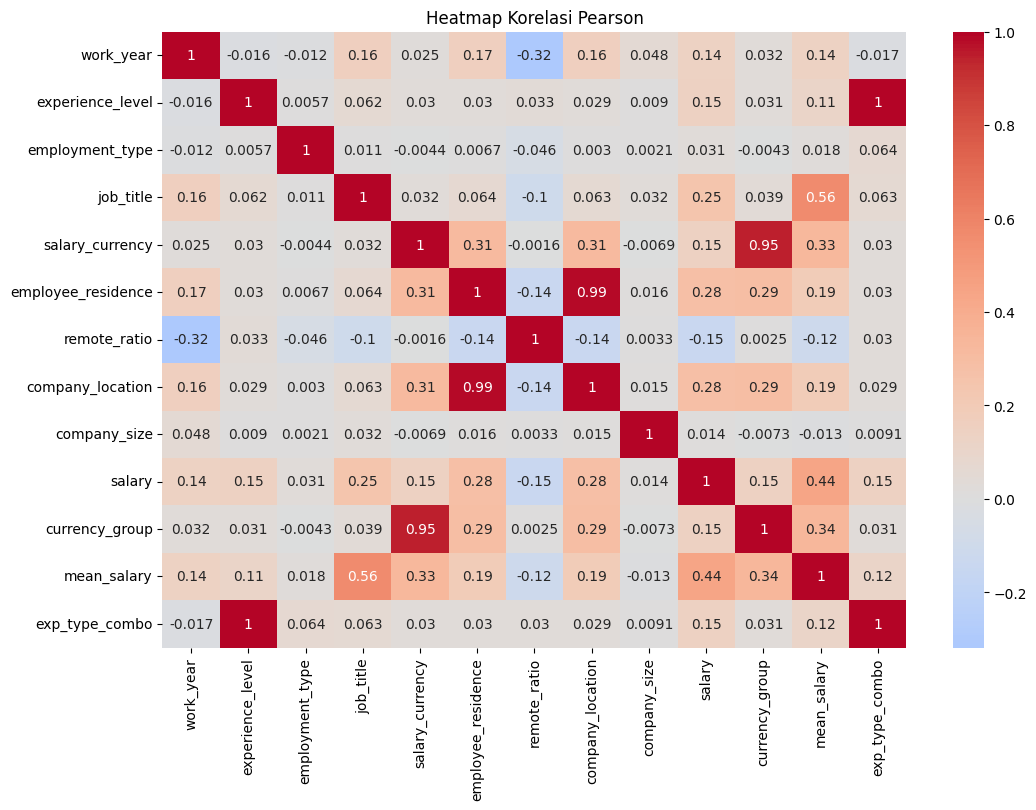

In [ ]:
# Copy dataset untuk praproses
df = train_df.copy()

# Label Encoding untuk fitur kategori
cat_cols = ['experience_level', 'employment_type', 'job_title', 'salary_currency','employee_residence', 'company_location', 'company_size',
            'currency_group', 'exp_type_combo']

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Menghitung korelasi Pearson untuk semua fitur
corr_matrix = df.corr()

# Visualisasi Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap= 'coolwarm', center=0)
plt.title("Heatmap Korelasi Pearson")
plt.show()

Dari matriks korelasi, diketahui bahwa tingkat korelasi fitur-fitur pemrediksi dengan fitur target mengalami perbaikan. Data cleaning success!

Catatan :

Setelah tahap evaluasi, diputuskan untuk tidak dilakukan penanganan distribusi yang skewed karena ternyata menghilangkan informasi-informasi penting bagi model yang ditandakan oleh peforma model yang menurun.


# Pemilihan Model (*Model Selection*)

Permasalahan Machine Learning kali ini adalah regresi, yaitu menentukan nilai numerik kontinue `salary` berdasarkan fitur-fitur tertentu. Sebagai tahap abstraksi, kita akan mengambil beberapa model terkenal, seperti Random Forest dan XGBoostRegressor sebagai *baseline model*.  Ini bertujuan untuk menguji beberapa algoritma secara cepat sehingga kita mendapatkan gambaran awal tentang kinerja mereka pada dataset.  

Alasan pemilihan *tree based model* adalah karena model jenis ini bisa menangani kardinalitas tinggi dan anomali dengan baik. Selain itu, model-model ini tidak memiliki banyak asumsi, seperti linearitas pada model regresi linear, sehingga cocok digunakan pada dataset dengan fitur yang heterogen seperti kasus prediksi gaji pegawai ini.

Olah dulu datanya ke dalam nilai numerik agar model bisa bekerja. Ini disebabkan model ML hanya mengerti angka, bukan objek.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Daftar kolom ordinal
ordinal_cols = ['experience_level', 'company_size']
# Urutan kategori untuk fitur ordinal
experience_order = ['EN', 'MI', 'SE', 'EX']
company_size_order = ['S', 'M', 'L']

# Daftar kolom kategorikal (non-ordinal)
cat_cols = ['employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location',
            'exp_type_combo', 'currency_group']

# Daftar kolom numerik
num_cols = ['work_year', 'remote_ratio', 'mean_salary']

# Pisahkan fitur dan target
X = train_df.drop(columns=['salary'])
y = train_df['salary']

# Split the train, test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat encoder untuk kolom ordinal
ordinal_encoder = OrdinalEncoder(categories=[experience_order, company_size_order])

# Buat transformer menggunakan ColumnTransformer
transform = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_encoder, ordinal_cols),  # Menggunakan OrdinalEncoder untuk fitur ordinal
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)  # Menggunakan OneHotEncoder untuk fitur kategorikal lainnya
    ],
    remainder='passthrough'  # Lewatkan kolom numerik tanpa perubahan
)

# Fit dan transform data latih
X_train_transformed = transform.fit_transform(X_train)

# Fit dan transform data uji
X_test_transformed = transform.transform(X_test)

# Cek hasil transformasi
print(f"Shape X_train_transformed: {X_train_transformed.shape}")
print(f"Shape X_test_transformed: {X_test_transformed.shape}")

Shape X_train_transformed: (26679, 373)
Shape X_test_transformed: (6670, 373)


Random Forest

In [ ]:
# Make RandomForestRegressor rf_reg
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the rf_reg to the transformed training data
rf_reg.fit(X_train_transformed, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Use the model to make predictions on the transformed test data
y_pred = rf_reg.predict(X_test_transformed)

# Calculate the mean squared error of the model on the test data
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

# calculate the root mean squared error
rmse = np.sqrt(mse)
print('Root mean squared error:', rmse)

Mean squared error: 4021920507.6703887
Root mean squared error: 63418.61325880903


Cross-Validation

In [ ]:
scores = cross_val_score(rf_reg, X_train_transformed, y_train, scoring='neg_mean_squared_error', cv=10)
rf_reg_rmse_scores = np.sqrt(-scores)
rf_reg_rmse_scores

# Calculate the average of the cross-validated RMSE scores
average_rmse = np.mean(rf_reg_rmse_scores)
print(f"Average RMSE across cross-validation folds: {average_rmse}")

# Optionally, you can also calculate other statistics like standard deviation
std_rmse = np.std(rf_reg_rmse_scores)
print(f"Standard deviation of RMSE across cross-validation folds: {std_rmse}")

Average RMSE across cross-validation folds: 63396.31927474346
Standard deviation of RMSE across cross-validation folds: 1345.1000745971828


XGBoost

In [ ]:
# Create XGBRegressor xgb_reg
xgb_reg = XGBRegressor(random_state=42)

# Fit the xgb_reg to the transformed training data
xgb_reg.fit(X_train_transformed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Use the model to make predictions on the transformed test data
y_pred = xgb_reg.predict(X_test_transformed)

# Calculate the mean squared error of the model on the test data
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

# calculate the root mean squared error
rmse = np.sqrt(mse)
print('Root mean squared error:', rmse)

Mean squared error: 3882929340.603784
Root mean squared error: 62313.155437706606


Cross-Validation

In [ ]:
scores = cross_val_score(xgb_reg, X_train_transformed, y_train, scoring='neg_mean_squared_error', cv=10)
xgb_reg_rmse_scores = np.sqrt(-scores)
xgb_reg_rmse_scores

# Calculate the average of the cross-validated RMSE scores
average_rmse = np.mean(xgb_reg_rmse_scores)
print(f"Average RMSE across cross-validation folds: {average_rmse}")

# Optionally, you can also calculate other statistics like standard deviation
std_rmse = np.std(xgb_reg_rmse_scores)
print(f"Standard deviation of RMSE across cross-validation folds: {std_rmse}")

Average RMSE across cross-validation folds: 61774.98534973579
Standard deviation of RMSE across cross-validation folds: 1356.1607062233002


Gradient Boosting

In [ ]:
# Create GradientBoostingRegressor gboost_reg
gboost_reg = GradientBoostingRegressor(random_state=42)

# Fit the gboost_reg to the transformed training data
gboost_reg.fit(X_train_transformed, y_train)

GradientBoostingRegressor(random_state=42)

In [ ]:
# Use the model to make predictions on the transformed test data
y_pred = gboost_reg.predict(X_test_transformed)

# Calculate the mean squared error of the model on the test data
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

# calculate the root mean squared error
rmse = np.sqrt(mse)
print('Root mean squared error:', rmse)

Mean squared error: 3875156709.0348926
Root mean squared error: 62250.75669447635


Cross-Validation

In [ ]:
scores = cross_val_score(gboost_reg, X_train_transformed, y_train, scoring='neg_mean_squared_error', cv=10)
gboost_reg_rmse_scores = np.sqrt(-scores)
gboost_reg_rmse_scores

# Calculate the average of the cross-validated RMSE scores
average_rmse = np.mean(gboost_reg_rmse_scores)
print(f"Average RMSE across cross-validation folds: {average_rmse}")

# Optionally, you can also calculate other statistics like standard deviation
std_rmse = np.std(gboost_reg_rmse_scores)
print(f"Standard deviation of RMSE across cross-validation folds: {std_rmse}")

Average RMSE across cross-validation folds: 61573.444799766105
Standard deviation of RMSE across cross-validation folds: 1211.3227148819371




---



Kita memasuki ulang tahap ini karena setelah melalui proses evaluasi, model XGBoost memiliki peforma yang lebih baik dibanding Gradient Boosting. Untuk itu, kita melanjutkan pencarian parameter terbaik untuk model tepilih.



---



Kita akan menggunakan GridSearchCV untuk menentukan parameter terbaik bagi model XGBoost Regressor.

Catatan : Setelah melakukan pencarian, model XGBoost bekerja lebih baik dengan parameter deafult. Kode di bawah ini bisa dilewati dan bisa langsung menuju tahap evaluasi. Running time kode ini akan sangat lama.

In [ ]:
'''

xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Parameter yang akan dicoba pada GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2],
}

# Menggunakan GridSearchCV dengan 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgbr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Anda bisa mengganti dengan metrik lain seperti 'r2' atau 'neg_mean_absolute_error'
    cv=5,
    verbose=3,
    n_jobs=-1
)

# Melatih model dengan GridSearchCV
grid_search.fit(X_train, y_train)

# Menampilkan hasil terbaik
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Mendapatkan model terbaik
best_model = grid_search.best_estimator_

# Menggunakan model terbaik untuk prediksi
y_pred = best_model.predict(X_test)

# Evaluasi model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

'''

' \nxgbr = xgb.XGBRegressor(objective=\'reg:squarederror\', random_state=42)\n\n# Parameter yang akan dicoba pada GridSearchCV\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [3, 5, 7],\n    \'learning_rate\': [0.01, 0.1, 0.2],\n    \'subsample\': [0.6, 0.8, 1.0],\n    \'colsample_bytree\': [0.6, 0.8, 1.0],\n    \'gamma\': [0, 0.1, 0.2],\n    \'reg_alpha\': [0, 0.01, 0.1],\n    \'reg_lambda\': [1, 1.5, 2],\n}\n\n# Menggunakan GridSearchCV dengan 5-fold cross-validation\ngrid_search = GridSearchCV(\n    estimator=xgbr,\n    param_grid=param_grid,\n    scoring=\'neg_mean_squared_error\',  # Anda bisa mengganti dengan metrik lain seperti \'r2\' atau \'neg_mean_absolute_error\'\n    cv=5,\n    verbose=3,\n    n_jobs=-1\n)\n\n# Melatih model dengan GridSearchCV\ngrid_search.fit(X_train, y_train)\n\n# Menampilkan hasil terbaik\nprint("Best parameters found: ", grid_search.best_params_)\nprint("Best score: ", grid_search.best_score_)\n\n# Mendapatkan model terbaik\

# Evaluasi Model (*Model Evaluation*)

Dari tahap Pemilihan Model, didapat statistik yang menyatakan bahwa Gradient Boosting `gboost_reg` memiliki peforma terbaik dengan rata-rata RMSE pada cross-validation sebesar 61573,85. Namun, setelah dievaluasi terhadap data tes asli pada platform Kaggle, model memiliki skor RMSE yang lebih buruk dibandingkan XGBoost Regressor `xgb_reg`. Setelah melakukan pencarian parameter terbaik, model bekerja optimal dengan parameter bawaan. Untuk itu, model yang dipilih pasca evaluasi adalah `xgb_reg` tanpa hyperparameter tuning.

In [ ]:
# Transform the test_df data with the ColumnTransformer
test_df_transformed = transform.transform(test_df)

# Predict on test_df
y_pred_test = xgb_reg.predict(test_df_transformed)

# Create a submission csv file
submission = pd.DataFrame({'ID': test_df.index, 'salary': y_pred_test})

# Save the submission file
submission.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import files

# Create a submission csv file
submission = pd.DataFrame({'ID': test_df.index, 'salary': y_pred_test})

# Save the submission file
submission.to_csv('submission.csv', index=False)

# Download the file
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>